In [1]:
from dl import authClient as ac, queryClient as qc, storeClient as sc, helpers
import pylab as plt
import numpy as np
from astropy.io import fits
import matplotlib as mpl
import math
import astropy.io.fits as fits
from astropy.table import Table 

In [2]:
token=ac.login('mgkadrmas')

In [3]:
ra=82
dec=-70
radius=0.5
df=Table(fits.getdata('LMCParallax4.fits'))
#res=qc.query(token,sql='select * from gaia_dr2.gaia_source where q3c_radial_query(ra,dec,'+str(ra)+','+str(dec)+','+str(radius)+')')
#cata=helpers.utils.convert(res,'table')

In [4]:
def onclick(event):
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    
    
    
def roi_cut(xcut,ycut,x,y): 
    from matplotlib.path import Path
    tupVerts = list(zip(xcut,ycut))
    points = np.vstack((x,y)).T
    p = Path(tupVerts) # make a polygon
    inside = p.contains_points(points)
    ind, = np.where(~inside)
    cutind, = np.where(inside)
    return ind, cutind
    print (ind, cutind)
    
    
    
def dist2LMCtest(ra, dec, pa, io):
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(81.9) #np.radians(82.25) #ra of LMC center
    delt0 = np.radians(-69.866667) #np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    io = np.radians(io) #inclination #25.86
    pa = np.radians(pa) #np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dist = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dist


def chi2(Dist, Distheory):
    chii=((Dist - Distheory)**2)/Distheory
    chi2=np.sum(chii)
    return chi2



In [5]:
xcut=[102.237903,99.022177,95.584677,90.372984,85.715726,75.625000,71.189516,67.752016,63.981855,62.207661,59.879032,58.770161,57.217742,56.219758,59.213710,63.870968,71.522177,78.840726,87.046371,93.256048,100.020161,103.014113,104.012097]
ycut=[-64.938814,-63.151940,-61.439520,-59.801552,-58.312490,-58.238037,-58.461396,-59.429286,-60.173817,-62.109597,-65.385533,-68.512562,-71.490685,-75.138886,-76.851306,-77.893650,-78.489274,-78.191462,-78.191462,-77.521384,-75.362245,-72.458575,-68.438109]
x=df['ra'].ravel()
y=df['dec'].ravel()
(ind, cutind) = roi_cut(xcut,ycut,x,y)


In [7]:
racenter=81.9
deccenter= -69.866667
distcenter=49

dist=1/df['parallax'].ravel()[cutind]

chitype = np.dtype([('theta',float),('inclin',float),('chi2val',float)])
chi2s = np.zeros([170,90], dtype=chitype)
for i in range (170):
    theta=i+191
    for j in range (90):
        inclin=j-17
        dtype=np.dtype([('ra',float),('dec',float),('distheory',float)])
        cat = np.zeros([56,26], dtype=dtype)
        for x in range (56):
            ra=x+55
            for y in range (26):
                dec=y-80
                (distheory) = dist2LMCtest(ra,dec,theta,inclin)
                cat[x,y]['ra']=ra
                cat[x,y]['dec']=dec
                cat[x,y]['distheory']=distheory
        chi2val = chi2(dist, cat['distheory'].ravel()[cutind])
        chi2s[i,j]['theta']=theta
        chi2s[i,j]['inclin']=inclin
        chi2s[i,j]['chi2val']=chi2val
        
chi2s = Table(chi2s)
chi2s.write('4LMCParallaxChi2.fits', format='fits')

In [6]:
chi2s=fits.getdata('4LMCParallaxChi2.fits')

In [7]:
pos = np.argmin(chi2s['chi2val'].data)
thetavals=chi2s['theta'].ravel()
thetamod=thetavals[pos]
inclinvals=chi2s['inclin'].ravel()
inclinmod=inclinvals[pos]
print(thetamod,inclinmod)

332.0 72.0


In [11]:
pa= thetamod 
io= inclinmod
dtype = np.dtype([('ra',float),('dec',float),('dist',float)])
dcat = np.zeros([56,26], dtype=dtype)
for i in range (56):
    ra=i+55
    for j in range (26):
        dec=j-80
        (dist) = dist2LMCtest(ra,dec,pa,io)
        dcat[i,j]['ra']=ra
        dcat[i,j]['dec']=dec
        dcat[i,j]['dist']=dist

In [47]:
noise= abs(df['parallax_error'].ravel()/((df['parallax'].ravel()**2)))

In [63]:
randval=np.random.randn(1456)

In [64]:
mod = dcat['dist'].ravel() + randval*noise
MCmodel=np.reshape(mod, (56,26))

In [65]:
randval*noise

4.188154619766419
9.016323890320955
-3.10305516924394
30.039033330770643
2.1085979761183506
8.395635777868977
3.085536840444674
-31.118995825757843
-22.371215412587393
87.1292289175589
-39.28658169843227


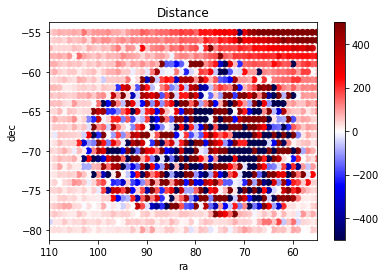

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('ra')
ax.set_ylabel('dec')
ax.set_xlim([110,55])
ax.set_title('Distance')
sc = ax.scatter(dcat['ra'],dcat['dec'], c=(MCmodel), vmin=-500, vmax=500, cmap=plt.cm.seismic)
fig.colorbar(sc)